In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pystackreg import StackReg
from skimage import io
import pandas as pd
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def overlay_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = np.stack(imgs, axis=0)

    return aggregator(imgs, axis=0)

def composite_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])
    
transformations = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}
prefix = './image_dir/'

/home/ubuntu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


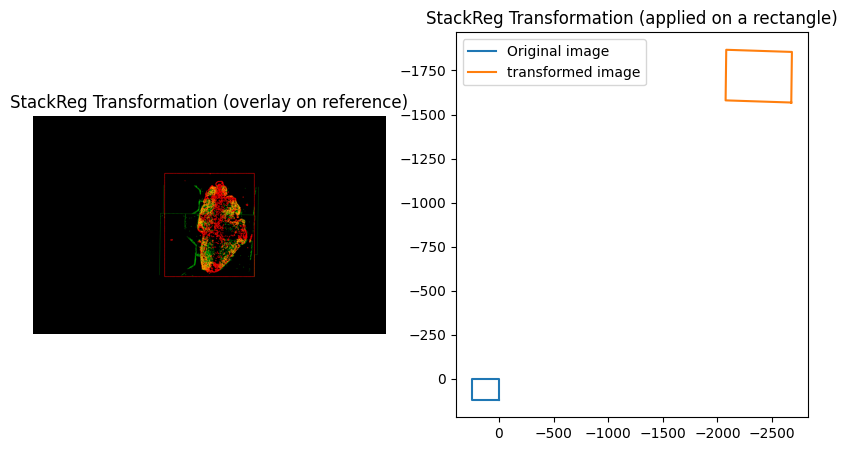

In [2]:
# Load the two .tif images
image1 = cv2.imread('Tissue_stitched.tif', cv2.IMREAD_GRAYSCALE)
image1 = cv2.resize(image1, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
image2 = cv2.imread('CytAssist_MCAK3_LCV01.tif', cv2.IMREAD_GRAYSCALE)
# Get the dimensions of the image
height, width = image2.shape

crop_start_x = (width // 4) + 130  # 25% from the left
crop_end_x = width - (width // 2)-100  # 25% from the right
crop_start_y = height // 3 +250  # 25% from the top
crop_end_y = height - (height // 3) -150 # 25% from the bottom
cropped_image = image2[crop_start_y:crop_end_y, crop_start_x:crop_end_x]
height, width = cropped_image.shape
cropped_image = cv2.flip(cropped_image, 1)
doubled_image = cv2.resize(cropped_image, (2 * width, 2 * height), interpolation=cv2.INTER_LINEAR)
image2 = doubled_image

cv2.imwrite(prefix + "cropped_visium.tif", image2)

image1 = io.imread(prefix + 'cropped_visium.tif', as_gray=True)
image2 = cv2.imread('Tissue_stitched.tif', cv2.IMREAD_GRAYSCALE)
image2 = cv2.resize(image2, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)


if image1 is not None and image2 is not None:
    # Get the dimensions of both images
    height1, width1 = image1.shape
    height2, width2 = image2.shape

    # Determine the maximum dimensions
    max_height = max(height1, height2)
    max_width = max(width1, width2)

    # Create a black background canvas with the maximum dimensions
    canvas1 = np.zeros((max_height, max_width), dtype=np.uint8)
    canvas2 = np.zeros((max_height, max_width), dtype=np.uint8)

    # Calculate the position to paste the first image onto the canvas
    x_offset1 = (max_width - width1) // 2
    y_offset1 = (max_height - height1) // 2

    # Calculate the position to paste the second image onto the canvas
    x_offset2 = (max_width - width2) // 2
    y_offset2 = (max_height - height2) // 2

    # Paste the first image onto the canvas with black background
    canvas1[y_offset1:y_offset1 + height1, x_offset1:x_offset1 + width1] = image1

    # Paste the second image onto the canvas with black background
    canvas2[y_offset2:y_offset2 + height2, x_offset2:x_offset2 + width2] = image2

cv2.imwrite(prefix + "matched_cropped_visium.tif", canvas1)
cv2.imwrite(prefix + "matched_cropped_afm.tif", canvas2)

blurred_image = cv2.GaussianBlur(canvas1, (5, 5), 0)
edges = cv2.Canny(blurred_image, 20, 30)
dilated_edges = cv2.dilate(edges, None, iterations=2)
canvas1 = dilated_edges


blurred_image = cv2.GaussianBlur(canvas2, (5, 5), 0)
edges = cv2.Canny(blurred_image, 30, 5)
dilated_edges = cv2.dilate(edges, None, iterations=2)
canvas2 = dilated_edges


cv2.imwrite(prefix + "matched_cropped_visium_edges.tif", canvas1)
cv2.imwrite(prefix + "matched_cropped_afm_edges.tif", canvas2)

ref = canvas1
mov = canvas2

f, ax = plt.subplots(1, 2, figsize=(10, 5))
before_reg = composite_images([ref, mov])
#potentially a diff trans
tf = StackReg.SCALED_ROTATION
sr = StackReg(tf)
reg = sr.register_transform(ref, mov)
reg = reg.clip(min=0)

after_reg = composite_images([ref, reg])

ax[0].imshow(after_reg, cmap='gray', vmin=0, vmax=1)
ax[0].set_title("StackReg Transformation" + ' (overlay on reference)')
ax[0].axis('off')
show_transformation(sr.get_matrix(), ax[1])

ax[1].set_title("StackReg Transformation" + ' (applied on a rectangle)')

plt.show()

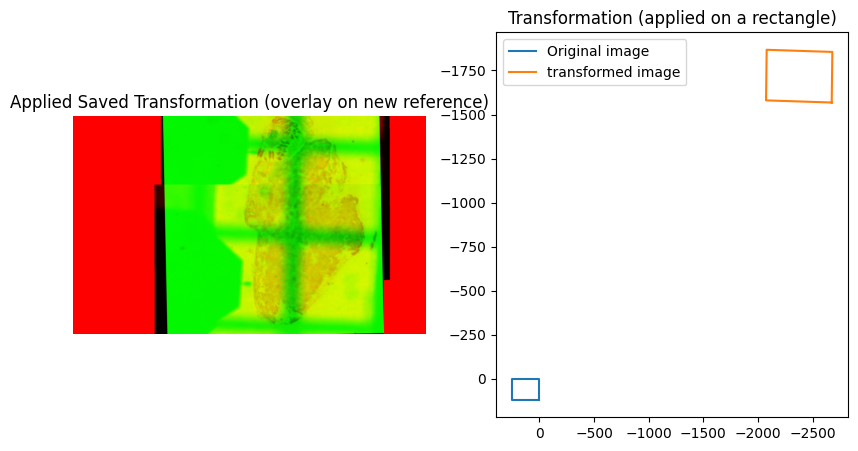

In [3]:
image1 = io.imread(prefix + 'matched_cropped_visium.tif', as_gray=True)
image2 = io.imread(prefix + 'matched_cropped_afm.tif', as_gray=True)

if image1 is not None and image2 is not None:
    # Get the dimensions of both images
    height1, width1 = image1.shape
    height2, width2 = image2.shape

    # Determine the maximum dimensions
    max_height = max(height1, height2)
    max_width = max(width1, width2)

    # Create a black background canvas with the maximum dimensions
    canvas1 = np.zeros((max_height, max_width), dtype=np.uint8)
    canvas2 = np.zeros((max_height, max_width), dtype=np.uint8)

    # Calculate the position to paste the first image onto the canvas
    x_offset1 = (max_width - width1) // 2
    y_offset1 = (max_height - height1) // 2

    # Calculate the position to paste the second image onto the canvas
    x_offset2 = (max_width - width2) // 2
    y_offset2 = (max_height - height2) // 2

    # Paste the first image onto the canvas with black background
    canvas1[y_offset1:y_offset1 + height1, x_offset1:x_offset1 + width1] = image1

    # Paste the second image onto the canvas with black background
    canvas2[y_offset2:y_offset2 + height2, x_offset2:x_offset2 + width2] = image2

ref = canvas1
mov = canvas2

#potentially a diff trans

transformation_matrix = sr.get_matrix()
reg_new = cv2.warpPerspective(ref, transformation_matrix, (mov.shape[1], mov.shape[0]))
after_reg_new = composite_images([mov, reg_new])

# Visualization (you might have defined composite_images and other visualization functions elsewhere)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(after_reg_new, cmap='gray', vmin=0, vmax=1)
ax[0].set_title("Applied Saved Transformation" + ' (overlay on new reference)')
ax[0].axis('off')

# You can reuse the function to show how the transformation matrix would be applied on a geometric shape
# Assuming you have a function `show_transformation` that visualizes the effect of the transformation matrix
show_transformation(transformation_matrix, ax[1])
ax[1].set_title("Transformation" + ' (applied on a rectangle)')
plt.show()


### Loading AFM/Spatial Data

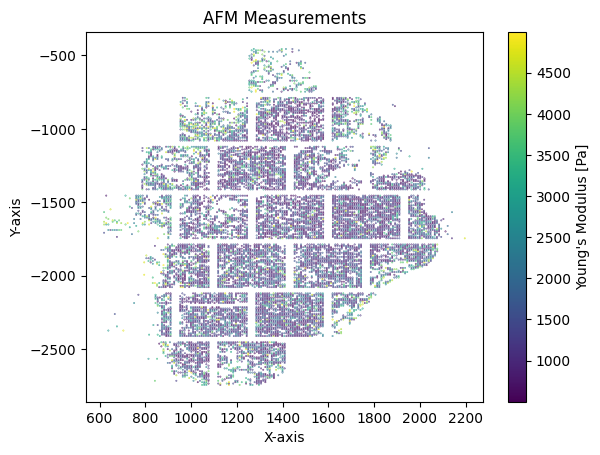

In [4]:
afm = pd.read_csv("../../STDeconvolve/MCAK2_Merge_AFM.tsv", sep = "\t")
afm_slide = cv2.imread(prefix +'matched_cropped_afm.tif', cv2.IMREAD_GRAYSCALE)

# Define a threshold for Young's Modulus [Pa]
threshold = 5000  # Adjust this threshold to your specific needs
afm['Y Position'] = (afm['Y Position'])*-1
afm['Y Position'] = (afm['Y Position'])*1e6
afm['X Position'] = (afm['X Position'])*1e6

# Filter the data to exclude outliers
filtered_afm = afm[afm["Young's Modulus [Pa]"] < threshold]

filtered_afm = filtered_afm[filtered_afm["Young's Modulus [Pa]"] > 500]


# Create a scatter plot with colors representing 'Young's Modulus [Pa]'
plt.scatter(filtered_afm['Y Position'], filtered_afm['X Position'], c=filtered_afm["Young's Modulus [Pa]"], s=0.1)

# Add labels and a title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('AFM Measurements')

# Add a color bar
colorbar = plt.colorbar()
colorbar.set_label("Young's Modulus [Pa]")


plt.show()

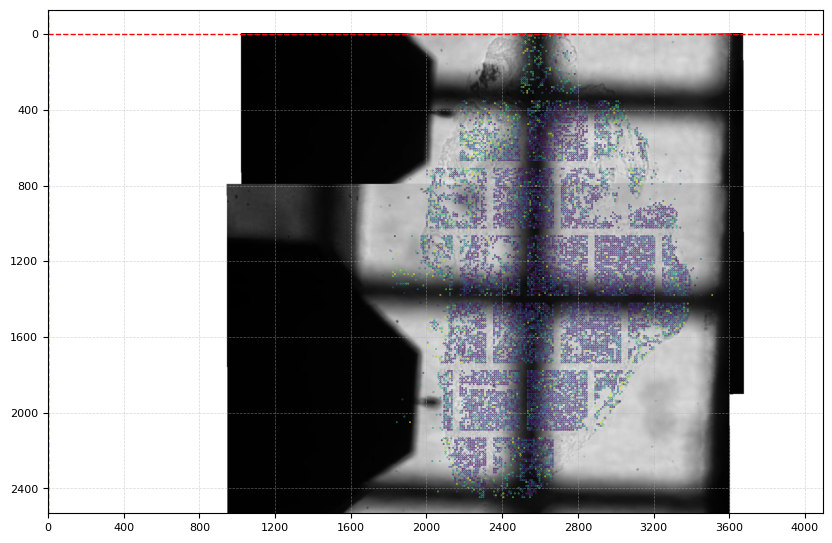

In [5]:
canvas = np.zeros_like(afm_slide)

# Check if the dimensions match
if canvas.shape[:2] == afm_slide.shape[:2]:
    # Draw the resized image on the canvas
    canvas = cv2.addWeighted(canvas, 1, afm_slide, 1, 0)  # Overlay the image on the canvas

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap='gray')  # Specify the grayscale colormap

    plt.scatter(filtered_afm['Y Position']*1.07+1160, filtered_afm['X Position']*-1.07-490, 
                c=filtered_afm["Young's Modulus [Pa]"], s=0.1)

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas.shape[1], step=400), fontsize=8)
    plt.yticks(np.arange(0, canvas.shape[0], step=400), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")


transformed_afm = filtered_afm

transformed_afm["X"] = filtered_afm['Y Position']*1.07+1160
transformed_afm["Y"] = filtered_afm['X Position']*-1.07-490

In [6]:
def apply_transformation(row, sr):
    # Extract X and Y coordinates from the row
    x_ref, y_ref = row["X"], row["Y"]

    # Create a homogenous coordinate
    coordinate_ref = np.array([x_ref, y_ref, 1])

    # Apply the transformation matrix obtained from StackReg
    transformed_coordinate_mov = np.dot(sr.get_matrix(), coordinate_ref)

    # Extract the transformed X and Y coordinates
    x_mov, y_mov, _ = transformed_coordinate_mov

    # Update the row with the transformed coordinates
    row["X"], row["Y"] = x_mov, y_mov

    return row

/tmp/ipykernel_37004/1255042360.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['X'] = (filtered_df['X'] * -2.0) + 4325.0
/tmp/ipykernel_37004/1255042360.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Y'] = (filtered_df['Y'] * 2.0) -1830


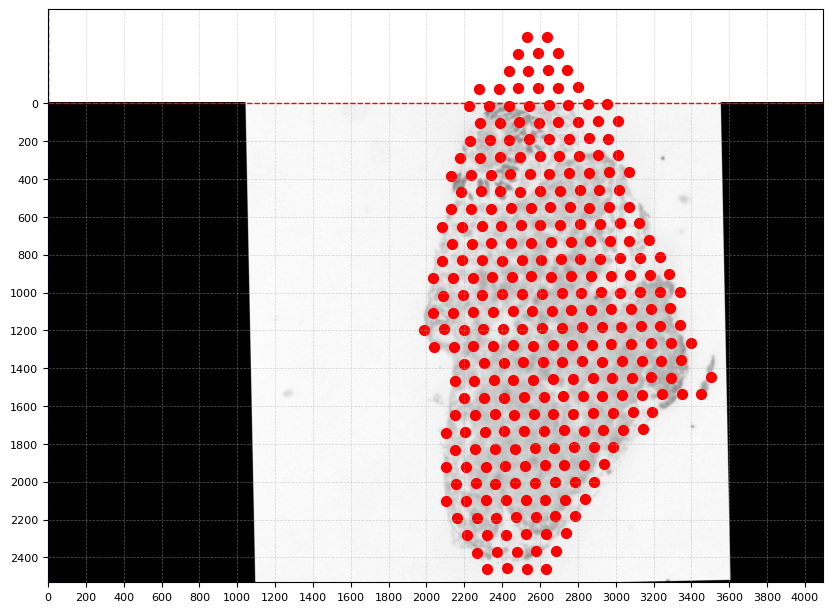

In [7]:
spatial_image = cv2.imread(prefix +'matched_cropped_visium.tif', cv2.IMREAD_GRAYSCALE)
spatial = pd.read_csv("../../spaceranger/LCV01/outs/spatial/Spatial-Projection.csv")
spatial_image = cv2.warpPerspective(spatial_image, transformation_matrix, (mov.shape[1], mov.shape[0]))

# Ensure that the dimensions of the canvas match the resized image
canvas = np.zeros_like(spatial_image)

# Check if the dimensions match
if canvas.shape[:2] == spatial_image.shape[:2]:
    # Draw the resized image on the canvas
    canvas = cv2.addWeighted(canvas, 1, spatial_image, 1, 0)  # Overlay the image on the canvas
    spatial['X']= spatial['X Coordinate'] 
    spatial['Y']= spatial['Y Coordinate']
    
    filtered_df = spatial[(spatial['X'] > 850)]
    filtered_df['X'] = (filtered_df['X'] * -2.0) + 4325.0
    filtered_df['Y'] = (filtered_df['Y'] * 2.0) -1830
    filtered_df = filtered_df.apply(apply_transformation, args=(sr,), axis=1)

    # Create a scatter plot on top of the canvas
    plt.figure(figsize=(10, 10))
    plt.imshow(canvas, cmap='gray')  # Specify the grayscale colormap

    plt.scatter(filtered_df['X'], filtered_df['Y'], s=50, color='red')

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal red dashed line for the X-axis
    plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical blue dashed line for the Y-axis

    # Specify axis tick positions and labels
    plt.xticks(np.arange(0, canvas.shape[1], step=200), fontsize=8)
    plt.yticks(np.arange(0, canvas.shape[0], step=200), fontsize=8)

    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.5)  # Add grid lines

    plt.show()
else:
    print("Error: Image dimensions do not match the canvas dimensions.")
spatial = filtered_df

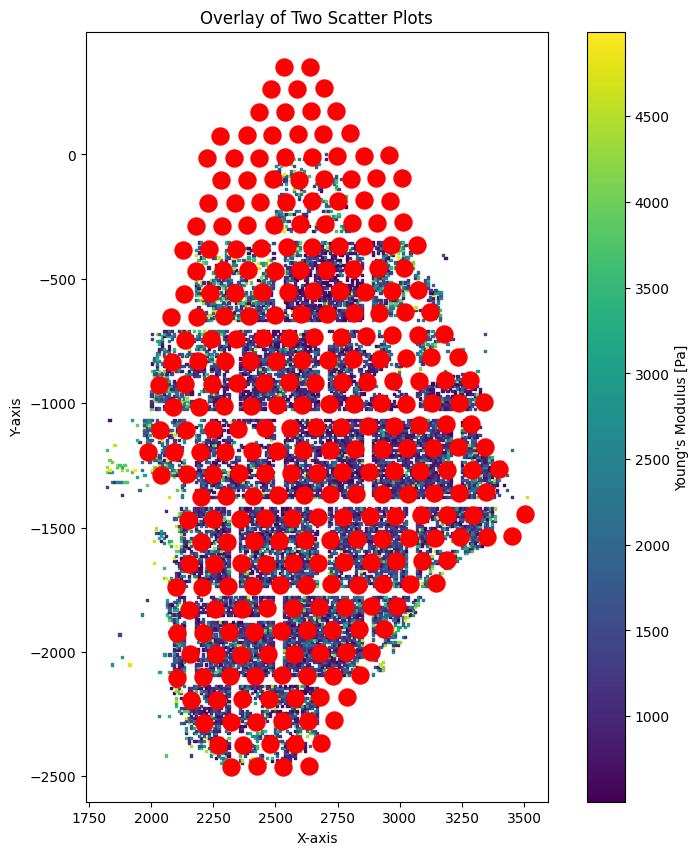

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed

filtered_df = spatial.copy()
scatter1 = ax.scatter(transformed_afm['X'], transformed_afm['Y']*-1, 
                      c=transformed_afm["Young's Modulus [Pa]"], 
                      s=2.5,
                      marker='s')

scatter2 = ax.scatter(filtered_df['X'], filtered_df['Y']*-1, s=150, color='red')

# Add labels and a title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Overlay of Two Scatter Plots')

# Add a color bar for the first scatter plot
colorbar = plt.colorbar(scatter1)
colorbar.set_label("Young's Modulus [Pa]")
ax.set_aspect('equal')

# Show the plot
plt.show()


In [25]:
import numpy as np
from numpy.linalg import lstsq
final_vals = []
final_residuals = [] 
estimated_ys = []
true_ys = []
def compute_ecm_affect(row_sums, ouput_matrix):
    return 0
    
input_matricies = []
output_matricies = []
cell_types = pd.read_csv("../../CytoSpace/cytospace_results/cell_type_assignments_by_spot.csv")
cell_types = cell_types.drop('Total cells', axis=1)

output_av_afm = []

radius =  35
for index, row_val in filtered_df.set_index("Barcode").iterrows():

    row_sums = np.array(cell_types[cell_types["SpotID"] == index].set_index("SpotID").values.flatten().tolist())
    #row_sums = row_sums / np.sum(row_sums)

    transformed_afm_2 =transformed_afm.copy()
    x_coord =row_val["X"]
    y_coord = row_val["Y"]
    transformed_afm_2['distance'] = np.sqrt((transformed_afm_2['X'] - x_coord)**2 + (transformed_afm_2['Y'] - y_coord)**2)
    print(len(transformed_afm_2[transformed_afm_2['distance'] < radius]["Young's Modulus [Pa]"]))
    output_matrix = np.mean(np.array(transformed_afm_2[transformed_afm_2['distance'] < radius]["Young's Modulus [Pa]"]))
    output_av_afm.append(output_matrix)
    print(output_matrix)
    print(row_val)
filtered_df["AvAFM"] = output_av_afm
filtered_df.to_csv("outs/analysis/AvAFM_Barcode.csv")

31
1709.423838709677
X Coordinate    1112.000000
Y Coordinate    1662.000000
X               2462.162313
Y               1646.151801
Name: AACACTTGGCAAGGAA-1, dtype: float64
19
2173.890894736842
X Coordinate    1198.000000
Y Coordinate    1511.000000
X               2032.012637
Y                925.435983
Name: AACTCAACCTTGACCA-1, dtype: float64
10
2284.4224
X Coordinate    1003.000000
Y Coordinate    1474.000000
X               2970.024983
Y                727.577636
Name: AACTGCCTCGATAGGT-1, dtype: float64
19
1701.6073157894737
X Coordinate    1176.000000
Y Coordinate    1474.000000
X               2134.610002
Y                744.598865
Name: AACTTCGCTTAGTCAG-1, dtype: float64
0
nan
X Coordinate    1100.000000
Y Coordinate    1305.000000
X               2484.985441
Y                -78.977697
Name: AAGATTATCTAGCATA-1, dtype: float64
32
1387.7130625
X Coordinate    1111.000000
Y Coordinate    1511.000000
X               2452.134622
Y                916.876174
Name: AAGCAGCGGACACGTG-1

/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

8
1327.2001249999998
X Coordinate    1133.000000
Y Coordinate    1511.000000
X               2345.896879
Y                919.040723
Name: CACGTCCACGACCTAT-1, dtype: float64
14
1420.3803571428573
X Coordinate     950.000000
Y Coordinate    1568.000000
X               3235.209894
Y               1176.287944
Name: CACTGGCCAGCCAGAT-1, dtype: float64
12
1381.9948333333334
X Coordinate    1165.000000
Y Coordinate    1568.000000
X               2196.977402
Y               1197.441494
Name: CAGATTCCGTATGCGA-1, dtype: float64
29
1041.3921379310345
X Coordinate    1068.000000
Y Coordinate    1549.000000
X               2663.519887
Y               1096.147021
Name: CAGATTGCCTGTAAGT-1, dtype: float64
0
nan
X Coordinate    1089.000000
Y Coordinate    1286.000000
X               2536.234929
Y               -171.810750
Name: CAGGACATGGTAATGC-1, dtype: float64
24
1735.3336666666667
X Coordinate    1155.000000
Y Coordinate    1812.000000
X               2269.274106
Y               2374.730761
Name: CA

/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

21
1955.783238095238
X Coordinate    1165.000000
Y Coordinate    1530.000000
X               2193.238635
Y               1013.939937
Name: GAACAGATAACCTTAA-1, dtype: float64
0
nan
X Coordinate    1067.000000
Y Coordinate    1249.000000
X               2638.832294
Y               -352.647868
Name: GAACTAACTCTACGTG-1, dtype: float64
0
nan
X Coordinate    1154.000000
Y Coordinate    1361.000000
X               2229.729833
Y                196.758634
Name: GAACTGTAACTCAGGC-1, dtype: float64
13
1468.5592307692305
X Coordinate    1188.00000
Y Coordinate    1755.00000
X               2104.30934
Y               2102.72525
Name: GAACTTGGTGAGGATA-1, dtype: float64
35
1473.9771999999998
X Coordinate    1004.000000
Y Coordinate    1587.000000
X               2976.313908
Y               1273.351707
Name: GAATAAGGAGAACTAA-1, dtype: float64
0
nan
X Coordinate     896.000000
Y Coordinate    1625.000000
X               3501.583415
Y               1446.227294
Name: GAATGACACGACTAGG-1, dtype: float64
27


/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

0
nan
X Coordinate    1057.000000
Y Coordinate    1305.000000
X               2692.631939
Y                -83.208407
Name: GTTAACTCCGACCACT-1, dtype: float64
11
2798.0427272727275
X Coordinate    1111.000000
Y Coordinate    1399.000000
X               2441.115098
Y                376.029481
Name: GTTGACGAACCAGAAC-1, dtype: float64
13
1145.618
X Coordinate    1025.000000
Y Coordinate    1549.000000
X               2871.166386
Y               1091.916311
Name: GTTGACTAGAGCACGT-1, dtype: float64
5
2478.992
X Coordinate    1198.000000
Y Coordinate    1586.000000
X               2039.391782
Y               1287.610108
Name: GTTGTCCTGTGATGTA-1, dtype: float64
19
1416.9155263157897
X Coordinate    1046.000000
Y Coordinate    1399.000000
X               2754.999340
Y                369.634221
Name: TAACGTCACTATAATC-1, dtype: float64
4
2246.6125
X Coordinate     960.000000
Y Coordinate    1474.000000
X               3177.671482
Y                723.346926
Name: TAAGTGGCCGCTCACC-1, dtype: float

/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar 